In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import os
import numpy as np
import rasterio
from rasterio import features
from rasterio.warp import reproject, Resampling

In [3]:
repd_path = "/Users/hester/Desktop/Assignment 2/REPD_Publication_Q3_2025.csv"        # REPD CSV
countries_shp = "/Users/hester/Desktop/Assignment 2/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"      # countries
coastline_shp = "/Users/hester/Desktop/Assignment 2/ne_110m_coastline/ne_110m_coastline.shp"              # coastline
uk_parts_path = "/Users/hester/Desktop/Assignment 2/Countries/CTRY_DEC_2022_UK_BFC_v2_c.shp"

In [4]:
repd = pd.read_csv(repd_path,encoding="latin1")
print(repd.columns)
repd.head()

Index(['Old Ref ID', 'Ref ID', 'Record Last Updated (dd/mm/yyyy)',
       'Operator (or Applicant)', 'Site Name', 'Technology Type',
       'Storage Type', 'Storage Co-location REPD Ref ID',
       'Installed Capacity (MWelec)', 'Share Community Scheme', 'CHP Enabled',
       'CfD Allocation Round', 'RO Banding (ROC/MWh)', 'FiT Tariff (p/kWh)',
       'CfD Capacity (MW)', 'Turbine Capacity', 'No. of Turbines',
       'Height of Turbines (m)', 'Mounting Type for Solar',
       'Development Status', 'Development Status (short)',
       'Are they re-applying (New REPD Ref)',
       'Are they re-applying (Old REPD Ref) ', 'Address', 'County', 'Region',
       'Country', 'Post Code', 'X-coordinate', 'Y-coordinate',
       'Planning Authority', 'Planning Application Reference',
       'Appeal Reference', 'Secretary of State Reference',
       'Type of Secretary of State Intervention', 'Judicial Review',
       'Offshore Wind Round', 'Planning Application Submitted',
       'Planning Applicat

,Old Ref ID,Ref ID,Record Last Updated (dd/mm/yyyy),Operator (or Applicant),Site Name,Technology Type,Storage Type,Storage Co-location REPD Ref ID,Installed Capacity (MWelec),Share Community Scheme,...,Appeal Granted,Planning Permission Granted,Secretary of State - Intervened,Secretary of State - Refusal,Secretary of State - Granted,Planning Permission Expired,Under Construction,Operational,Heat Network Ref,Solar Site Area (sqm)
0,1,10726459,07/07/2009,RWE npower,Aberthaw Power Station Biomass,Biomass (co-firing),NaN,NaN,35.00,NaN,...,NaN,03/09/2004,NaN,NaN,NaN,NaN,01/05/2006,01/05/2007,NaN,NaN
1,2,NaN,20/11/2017,Orsted (formerly Dong Energy) / Peel Energy,Hunterston - cofiring,Biomass (co-firing),NaN,NaN,170.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,12019680,20/12/2019,Scottish and Southern Energy (SSE),Ferrybridge Multifuel 2 (FM2),EfW Incineration,NaN,NaN,70.00,NaN,...,NaN,28/10/2015,NaN,NaN,NaN,28/10/2020,01/09/2016,20/12/2019,NaN,NaN
3,4,11877116,18/12/2003,Energy Power Resources,Thetford Biomass Power Station,Biomass (dedicated),NaN,NaN,38.50,NaN,...,NaN,05/05/1995,NaN,NaN,NaN,NaN,NaN,02/10/1998,NaN,NaN
4,5,NaN,29/09/2005,Agrigen,Nunn Mills Road Biomass Plant,Biomass (dedicated),NaN,NaN,8.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#只保留陆上风电
df_onshore = repd[repd["Technology Type"] == "Wind Onshore"].copy()

In [6]:
#删除缺失坐标的数据
df_onshore = df_onshore.dropna(
    subset=["X-coordinate", "Y-coordinate"])

In [7]:
#删除明显无用的列
keep_cols = [
    "Site Name",
    "Technology Type",
    "X-coordinate",
    "Y-coordinate",
    "Installed Capacity (MWelec)"
]

df_onshore_clean = df_onshore[keep_cols].copy()

In [8]:
#重新命名
TECH_COL = "Technology Type"
STATUS_COL = "Development Status (short)"
XCOL = "X-coordinate"
YCOL = "Y-coordinate"

In [9]:
onshore_df = repd[repd[TECH_COL] == "Wind Onshore"].copy()
offshore_df = repd[repd[TECH_COL] == "Wind Offshore"].copy()
print("原始 Wind Onshore 行数:", len(onshore_df))
print("原始 Wind Offshore 行数:", len(offshore_df))

原始 Wind Onshore 行数: 2657
原始 Wind Offshore 行数: 101


In [10]:
onshore_df = onshore_df.dropna(subset=[XCOL, YCOL]).copy()
offshore_df = offshore_df.dropna(subset=[XCOL, YCOL]).copy()

print("有坐标的 Wind Onshore 行数:", len(onshore_df))
print("有坐标的 Wind Offshore 行数:", len(offshore_df))

有坐标的 Wind Onshore 行数: 2653
有坐标的 Wind Offshore 行数: 94


In [11]:
# 准备 onshore_df
onshore_df = repd[repd["Technology Type"] == "Wind Onshore"].copy()
onshore_df = onshore_df.dropna(subset=["X-coordinate", "Y-coordinate"])

# 加 status_clean
def simplify_status(status):
    s = str(status).lower()
    if "operat" in s:
        return "Operational"
    elif "construct" in s:
        return "Under Construction"
    else:
        return "Planning / Consented"

onshore_df["status_clean"] = onshore_df["Development Status"].apply(simplify_status)

In [12]:
# 构造 GeoDataFrame（注意 CRS = 27700）
onshore = gpd.GeoDataFrame(
    onshore_df,
    geometry=gpd.points_from_xy(onshore_df[XCOL], onshore_df[YCOL]),
    crs="EPSG:27700"   # British National Grid
)
# CRS转换
onshore = onshore.to_crs(epsg=4326)  

In [13]:
#读取英国边界
uk = gpd.read_file(countries_shp)
uk = uk[uk["ADMIN"] == "United Kingdom"]
coastline = gpd.read_file(coastline_shp)

uk = uk[uk["ADMIN"] == "United Kingdom"].to_crs(epsg=4326)

In [14]:
uk_parts = gpd.read_file(uk_parts_path)
uk_parts = uk_parts.to_crs(epsg=4326)

In [15]:
print(uk_parts.columns)
print(uk_parts.head())

Index(['CTRY22CD', 'CTRY22NM', 'CTRY22NMW', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'geometry'],
      dtype='object')
    CTRY22CD          CTRY22NM         CTRY22NMW   BNG_E   BNG_N     LONG  \
0  E92000001           England            Lloegr  394883  370883 -2.07811   
1  N92000002  Northern Ireland  Gogledd Iwerddon   86544  535337 -6.85570   
2  S92000003          Scotland          Yr Alban  277744  700060 -3.97094   
3  W92000004             Wales             Cymru  263405  242881 -3.99417   

       LAT                                           geometry  
0  53.2350  MULTIPOLYGON (((-6.39946 49.86527, -6.39935 49...  
1  54.6150  MULTIPOLYGON (((-6.10769 54.04134, -6.10766 54...  
2  56.1774  MULTIPOLYGON (((-4.08528 54.76859, -4.08527 54...  
3  52.0674  MULTIPOLYGON (((-3.12097 51.38017, -3.12097 51...  


In [16]:
color_map = {
    "England": "#E6D8B8",          # 淡沙色
    "Scotland": "#C7DDE8",         # 淡蓝灰
    "Wales": "#D6E5D8",            # 淡绿灰
    "Northern Ireland": "#E8D6D6", # 淡粉灰
}

uk_parts["fill"] = uk_parts["CTRY22NM"].map(color_map).fillna("#EEEEEE")

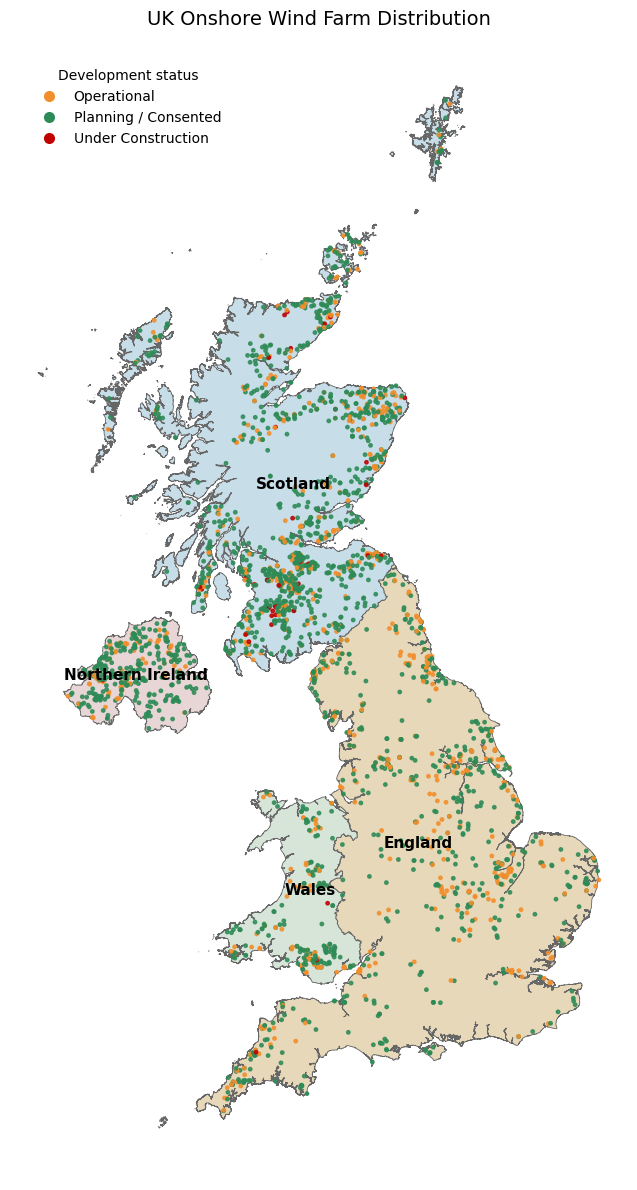

In [18]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8, 12)) 
uk_parts.plot(
    ax=ax,
    color=uk_parts["fill"],
    edgecolor="#666666", 
    linewidth=0.6,         
    zorder=1)

status_colors = {
    "Operational": "#F28E2B",         
    "Planning / Consented": "#2E8B57",
    "Under Construction": "#C00000"}

onshore.plot(
    ax=ax,
    markersize=6,
    color=onshore["status_clean"].map(status_colors),
    alpha=0.85,
    zorder=2,
    legend=False)

handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor=status_colors["Operational"], markeredgecolor='none',
           markersize=8, label="Operational"),
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor=status_colors["Planning / Consented"], markeredgecolor='none',
           markersize=8, label="Planning / Consented"),
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor=status_colors["Under Construction"], markeredgecolor='none',
           markersize=8, label="Under Construction")]

leg = ax.legend(
    handles=handles,
    title="Development status",
    loc="upper left",
    bbox_to_anchor=(0.02, 0.98),
    frameon=True)

leg.get_frame().set_facecolor("white")
leg.get_frame().set_alpha(0.85)
leg.get_frame().set_linewidth(0)

uk_parts["label_point"] = uk_parts.geometry.representative_point()

for idx, row in uk_parts.iterrows():
    ax.text(
        row["label_point"].x,
        row["label_point"].y,
        row["CTRY22NM"],
        fontsize=11,
        fontweight="bold",
        ha="center",
        va="center",
        color="black")

ax.set_axis_off()
ax.set_title("UK Onshore Wind Farm Distribution", fontsize=14)

plt.tight_layout()
plt.show()
fig.savefig("UK Onshore Wind Farm Distribution.png", dpi=300, bbox_inches="tight")

In [25]:
offshore = gpd.GeoDataFrame(
    offshore_df,
    geometry=gpd.points_from_xy(offshore_df[XCOL], offshore_df[YCOL]),
    crs="EPSG:27700"
).to_crs(epsg=4326)

In [26]:
ocean = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip")
ocean_27700 = ocean.to_crs(epsg=27700)

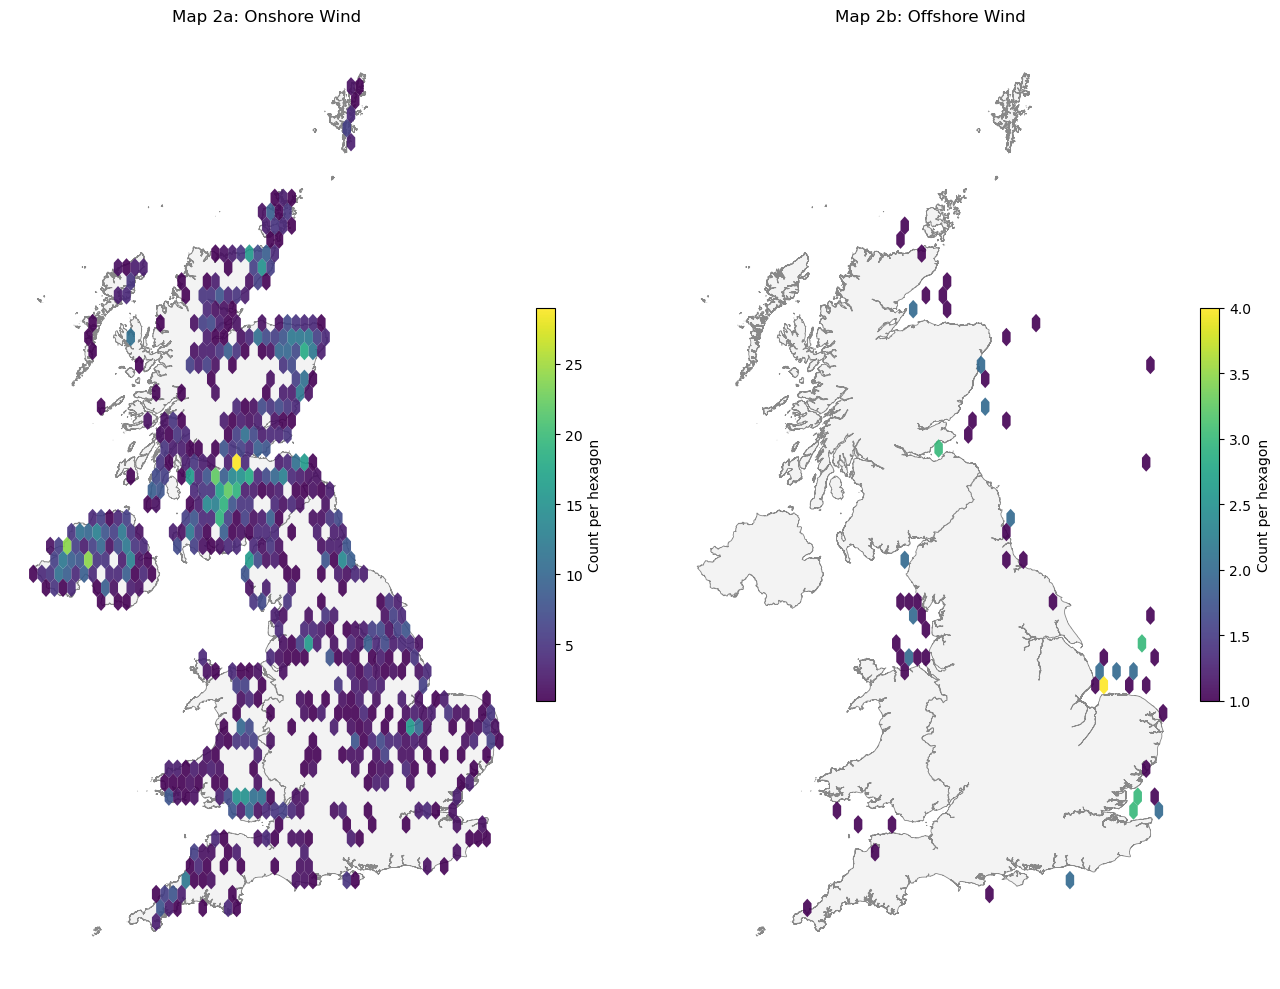

In [28]:
onshore_27700  = onshore.to_crs(epsg=27700)
offshore_27700 = offshore.to_crs(epsg=27700)
uk_parts_27700 = uk_parts.to_crs(epsg=27700)

minx, miny, maxx, maxy = uk_parts_27700.total_bounds

x_on  = onshore_27700.geometry.x.values
y_on  = onshore_27700.geometry.y.values
x_off = offshore_27700.geometry.x.values
y_off = offshore_27700.geometry.y.values

fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharex=True, sharey=True)

ax = axes[0]
uk_parts_27700.plot(ax=ax, color="#F3F3F3", edgecolor="#888888", linewidth=0.6, zorder=1)

hb1 = ax.hexbin(
    x_on, y_on,
    gridsize=55,         
    extent=(minx, maxx, miny, maxy),
    mincnt=1,
    linewidths=0,
    alpha=0.9,
    zorder=2)
ax.set_title("Spatial Distribution of Onshore and Offshore Wind Power in the UK", fontsize=14)
ax.set_title("Map 2a: Onshore Wind")
ax.set_axis_off()
cb1 = fig.colorbar(hb1, ax=ax, fraction=0.03, pad=0.02)
cb1.set_label("Count per hexagon")

ax = axes[1]
uk_parts_27700.plot(ax=ax, color="#F3F3F3", edgecolor="#888888", linewidth=0.6, zorder=1)

hb2 = ax.hexbin(
    x_off, y_off,
    gridsize=55,
    extent=(minx, maxx, miny, maxy),
    mincnt=1,
    linewidths=0,
    alpha=0.9,
    zorder=2)
ax.set_title("Map 2b: Offshore Wind")
ax.set_axis_off()
cb2 = fig.colorbar(hb2, ax=ax, fraction=0.03, pad=0.02)
cb2.set_label("Count per hexagon")

plt.tight_layout()
plt.show()
fig.savefig("Spatial Distribution of Onshore and Offshore Wind Power in the UK", dpi=300, bbox_inches="tight")